In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import random
import time
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingRegressor


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

warnings.filterwarnings("ignore")

/kaggle/input/flight-price-prediction/business.csv
/kaggle/input/flight-price-prediction/economy.csv
/kaggle/input/flight-price-prediction/Clean_Dataset.csv
/kaggle/input/saved-predictions/mean_of_predictions.csv
/kaggle/input/saved-predictions/cbr_tuned_train_pred_y.csv
/kaggle/input/saved-predictions/mlp_tuned_train_pred_y.csv
/kaggle/input/saved-predictions/xgb_tuned_train_pred_y.csv
/kaggle/input/saved-predictions/cbr_tuned_test_pred_y.csv
/kaggle/input/saved-predictions/xgb_tuned_test_pred_y.csv
/kaggle/input/saved-predictions/rfr_tuned_test_pred_y.csv
/kaggle/input/saved-predictions/mlp_tuned_test_pred_y.csv
/kaggle/input/saved-predictions/rfr_tuned_train_pred_y.csv


# Read Data in and do head

In [2]:
np.random.seed(42)
dataset = pd.read_csv("../input/flight-price-prediction/Clean_Dataset.csv", index_col=0)

dataset.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


# Value Counts for much of the columns.

In [3]:
cols = ["airline", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class"]

for col in cols:
    print("Column Value Counts: ", col)
    print(dataset[col].value_counts())
    print()

Column Value Counts:  airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64

Column Value Counts:  source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: source_city, dtype: int64

Column Value Counts:  departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: departure_time, dtype: int64

Column Value Counts:  stops
one            250863
zero            36004
two_or_more     13286
Name: stops, dtype: int64

Column Value Counts:  arrival_time
Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: arrival_time, dtype: int64

Column Value Counts:  destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Kolka

# Drop flight column

In [4]:
dataset.drop("flight", axis=1, inplace=True)

# Change stops to numerical data

In [5]:
def change_stops(data_record):
    if data_record == "zero":
        return 0
    elif data_record == "one":
        return 1
    else:
        return 2

In [6]:
dataset["stops"] = dataset["stops"].apply(change_stops)

In [7]:
dataset["stops"].value_counts()

1    250863
0     36004
2     13286
Name: stops, dtype: int64

In [8]:
def eda_plotting(graph_type, fig_size, x_data, y_data, hue_arg, order_arg, title_arg):
    
    plt.figure(figsize=fig_size)
    
    if graph_type == "barplot":
        sns.barplot(data=dataset, x=x_data, y=y_data, hue=hue_arg, order=order_arg)
        
    elif graph_type == "scatter":
        
        if hue_arg == None:
            sns.scatterplot(x=dataset[x_data], y=dataset[y_data])
        else:
            sns.scatterplot(x=dataset[x_data], y=dataset[y_data], hue=dataset[hue_arg])
    
    plt.title(title_arg)
    plt.show()
    

# Plot by airline

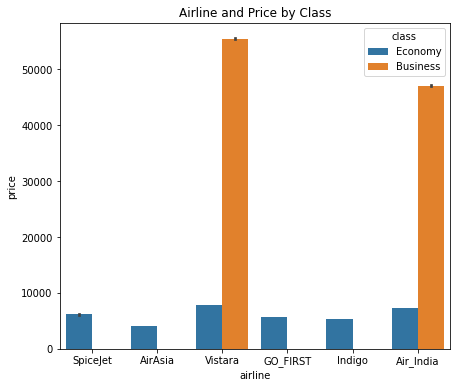

In [9]:
eda_plotting("barplot", [7, 6], "airline", "price", "class", None, "Airline and Price by Class")

# Business is much more expensive than economy and there are only 2 airlines that offer business.

# Get a distribution of the price

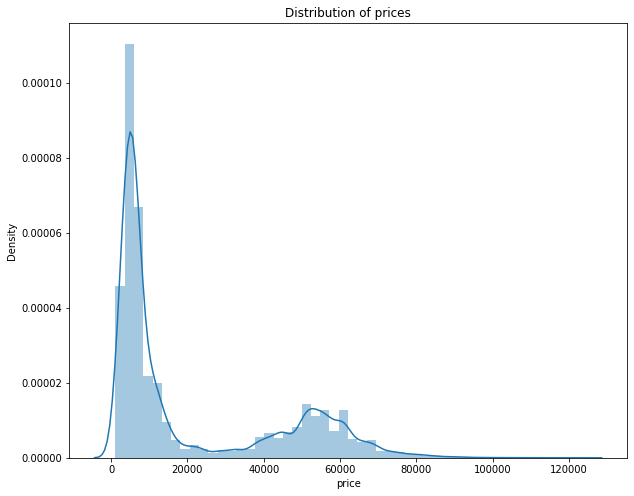

In [10]:
plt.figure(figsize=[10, 8])
sns.distplot(dataset["price"])
plt.title("Distribution of prices")
plt.show()

# Correlation heatmap for those features that are numeric

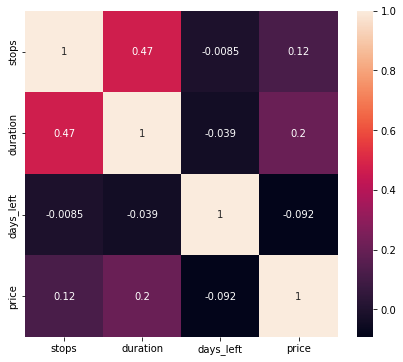

In [11]:
plt.figure(figsize=[7, 6])
sns.heatmap(dataset.corr(), annot=True)
plt.show()

# Show correlation between days left and pricing

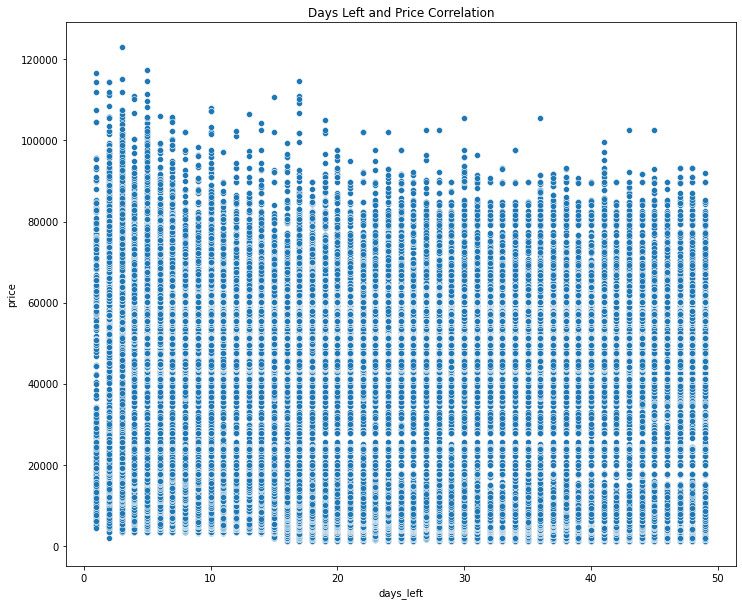

In [12]:
eda_plotting("scatter", [12, 10], "days_left", "price", None, None, "Days Left and Price Correlation")

# There is no correlation between the days left and price. The heatmap and scatter plot confirm this. days left will be dropped as a feature.

In [13]:
dataset.drop("days_left", axis=1, inplace=True)

# Find correlation between duration and price with class hue

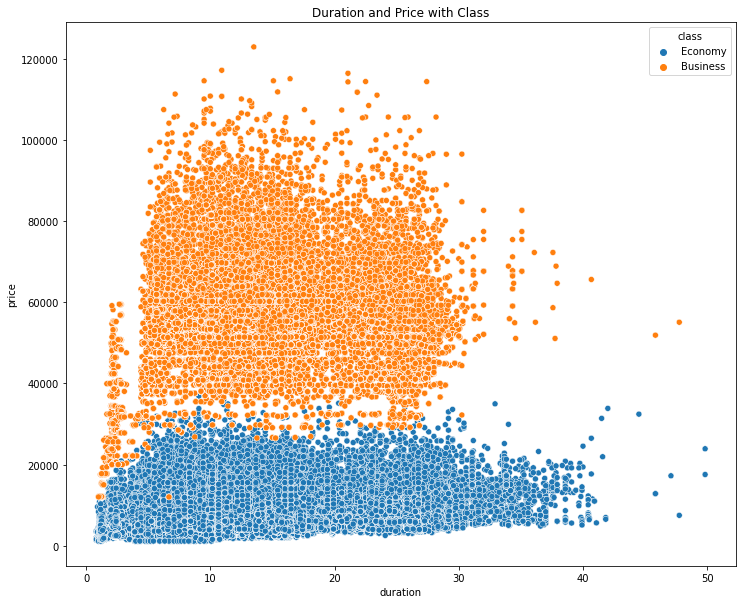

In [14]:
eda_plotting("scatter", [12, 10], "duration", "price", "class", None, "Duration and Price with Class")

# Strong correlation with the class variable. Not as strong correlation with duration but heatmap shows slight positive correlation.

# Let's see prices per city.

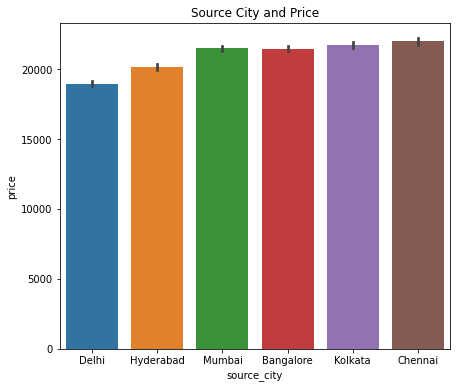

In [15]:
eda_plotting("barplot", [7, 6], "source_city", "price", None, ["Delhi", "Hyderabad", "Mumbai", "Bangalore", "Kolkata", "Chennai"], "Source City and Price")

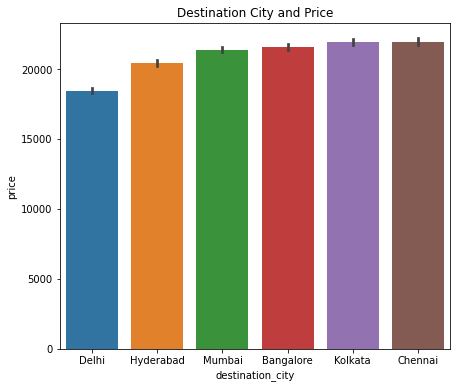

In [16]:
eda_plotting("barplot", [7, 6], "destination_city", "price", None, ["Delhi", "Hyderabad", "Mumbai", "Bangalore", "Kolkata", "Chennai"], "Destination City and Price")

# The prices for source city and destination city were pretty identical.

# Stops along with prices graph

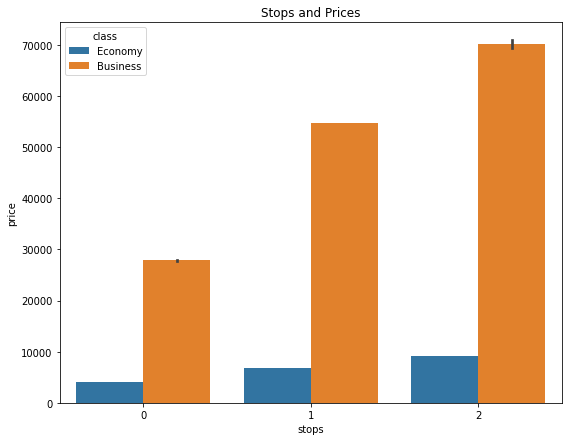

In [17]:
eda_plotting("barplot", [9, 7], "stops", "price", "class", None, "Stops and Prices")

# There is an increase in price when there are more stops, and price is very high with 2 or more stops and business class.

In [18]:
dataset[dataset["class"] == "Business"]["arrival_time"].value_counts()

Night            29025
Evening          26399
Morning          21786
Afternoon        10930
Early_Morning     3514
Late_Night        1833
Name: arrival_time, dtype: int64

In [19]:
dataset[dataset["class"] == "Economy"]["departure_time"].value_counts()

Morning          48821
Early_Morning    46688
Evening          44207
Afternoon        35245
Night            30537
Late_Night        1168
Name: departure_time, dtype: int64

# The two classes have similar distributions for departure and arrival time value counts. Late night times are not as common for both.

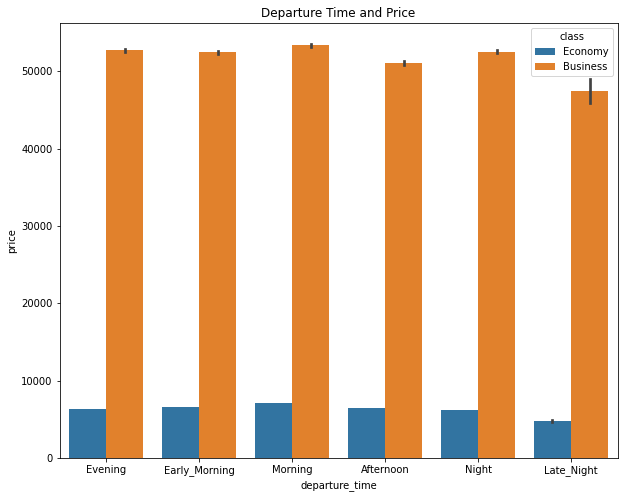

In [20]:
plt.figure(figsize=[10, 8])
sns.barplot(data=dataset, x="departure_time", y="price", hue="class", order=["Evening", "Early_Morning", "Morning", "Afternoon", "Night", "Late_Night"])
plt.title("Departure Time and Price")
plt.show()

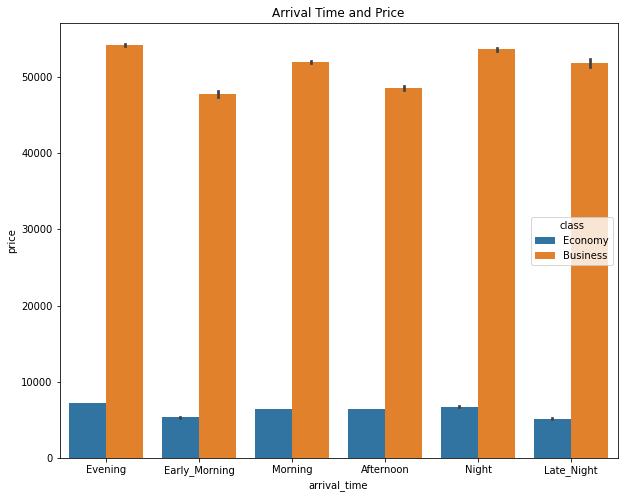

In [21]:
plt.figure(figsize=[10, 8])
sns.barplot(data=dataset, x="arrival_time", y="price", hue="class", order=["Evening", "Early_Morning", "Morning", "Afternoon", "Night", "Late_Night"])
plt.title("Arrival Time and Price")
plt.show()

# There are some slight variations between arrival and departure time prices. It's best to depart late at night and arrive early in the morning if you want a cheap flight. Morning departures and evening arrivals are the most expensive.

# Encode Features

In [22]:
encoded_dataset = pd.get_dummies(dataset)
encoded_dataset.head()

,stops,duration,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,...,arrival_time_Morning,arrival_time_Night,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy
0,0,2.17,5953,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
1,0,2.33,5953,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
2,0,2.17,5956,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,2.25,5955,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
4,0,2.33,5955,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1


# Get Column Names, convert to np array, encode data as another dataset

In [23]:
nonencoded_features = ["airline", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class", "duration"]
encoded_features = encoded_dataset.columns.tolist()
encoded_features = np.delete(encoded_features, 2, axis=0)
all_data = np.array(dataset)
all_x = all_data[:,0:8]
all_y = all_data[:,8]

all_data_encoded = np.array(encoded_dataset)
all_x_encoded = np.delete(all_data_encoded[:,0:len(encoded_dataset.columns)],2, axis=1)
all_y_encoded = all_data_encoded[:,2]

train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=.2, random_state=1)

train_x_encoded, test_x_encoded, train_y_encoded, test_y_encoded = train_test_split(all_x_encoded,
                                                                                    all_y_encoded, test_size=.2, random_state=1)
train_x_encoded.shape, train_y_encoded.shape, test_x_encoded.shape, test_y_encoded.shape
encoded_features



array(['stops', 'duration', 'airline_AirAsia', 'airline_Air_India',
       'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet',
       'airline_Vistara', 'source_city_Bangalore', 'source_city_Chennai',
       'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai',
       'departure_time_Afternoon', 'departure_time_Early_Morning',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Early_Morning',
       'arrival_time_Evening', 'arrival_time_Late_Night',
       'arrival_time_Morning', 'arrival_time_Night',
       'destination_city_Bangalore', 'destination_city_Chennai',
       'destination_city_Delhi', 'destination_city_Hyderabad',
       'destination_city_Kolkata', 'destination_city_Mumbai',
       'class_Business', 'class_Economy'], dtype='<U28')

# Train RandomForest Regressor and make predictions

In [24]:
rfr_start = time.time()
RFRmodel = RandomForestRegressor(random_state=1)
RFRmodel.fit(train_x_encoded, train_y_encoded)
RFR_train_pred_y = RFRmodel.predict(train_x_encoded)
RFR_test_pred_y = RFRmodel.predict(test_x_encoded)
rfr_stop = time.time()

# Train CatBoost Regressor and make predictions

In [25]:
dataset.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,price
0,SpiceJet,Delhi,Evening,0,Night,Mumbai,Economy,2.17,5953
1,SpiceJet,Delhi,Early_Morning,0,Morning,Mumbai,Economy,2.33,5953
2,AirAsia,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,2.17,5956
3,Vistara,Delhi,Morning,0,Afternoon,Mumbai,Economy,2.25,5955
4,Vistara,Delhi,Morning,0,Morning,Mumbai,Economy,2.33,5955


In [26]:
cbr_start = time.time()
CBRmodel = CatBoostRegressor(random_state=1, cat_features=[0, 1, 2, 4, 5, 6], verbose=False)
CBRmodel.fit(train_x, train_y, verbose=False)
CBR_train_pred_y = CBRmodel.predict(train_x)
CBR_test_pred_y = CBRmodel.predict(test_x)
cbr_stop = time.time()

# Train XGBoost

In [27]:
xgb_start = time.time()
XGBmodel = xgb.XGBRegressor(random_state=1)
XGBmodel.fit(train_x_encoded, train_y_encoded)
XGB_train_pred_y = XGBmodel.predict(train_x_encoded)
XGB_test_pred_y = XGBmodel.predict(test_x_encoded)
xgb_stop = time.time()

# Train MLP Regressor

In [28]:
mlp_start = time.time()
MLPmodel = MLPRegressor(random_state=1)
MLPmodel.fit(train_x_encoded, train_y_encoded)
MLP_train_pred_y = MLPmodel.predict(train_x_encoded)
MLP_test_pred_y = MLPmodel.predict(test_x_encoded)
mlp_stop = time.time()

# Evaluate model with R^2/MAE/MSE

In [29]:
def evaluate(model, tr_x, tr_y, test_x, test_y, train_pred_y, test_pred_y):
    train_r2 = model.score(tr_x, tr_y)
    test_r2 = model.score(test_x, test_y)
    
    train_mae = mean_absolute_error(train_pred_y, tr_y)
    test_mae = mean_absolute_error(test_pred_y, test_y)
    
    return train_r2, test_r2, train_mae, test_mae

In [30]:
rfr_train_r2, rfr_test_r2, rfr_train_mae, rfr_test_mae = evaluate(RFRmodel, train_x_encoded, train_y_encoded, test_x_encoded, test_y_encoded, RFR_train_pred_y, RFR_test_pred_y)
cbr_train_r2, cbr_test_r2, cbr_train_mae, cbr_test_mae = evaluate(CBRmodel, train_x, train_y, test_x, test_y, CBR_train_pred_y, CBR_test_pred_y) 
xgb_train_r2, xgb_test_r2, xgb_train_mae, xgb_test_mae = evaluate(XGBmodel, train_x_encoded, train_y_encoded, test_x_encoded, test_y_encoded, XGB_train_pred_y, XGB_test_pred_y)
mlp_train_r2, mlp_test_r2, mlp_train_mae, mlp_test_mae = evaluate(MLPmodel, train_x_encoded, train_y_encoded, test_x_encoded, test_y_encoded, MLP_train_pred_y, MLP_test_pred_y)

# Show table of models, accuracies, and runtimes

In [31]:
def create_eval_table(mae_list, r2_list, run_time_list):
    
    evaluation_table = pd.DataFrame({
    
     "Model" : ["Random Forest Regressor", "Catboost Regressor", "XGBoost Regressor", "MLP Regressor"],
     "MAE" : mae_list,
     "R^2" : r2_list,
     "Train and Predict Run Time (s)" : run_time_list
    })
    
    return evaluation_table

In [32]:
train_mae_list = [round(rfr_train_mae), round(cbr_train_mae), round(xgb_train_mae), round(mlp_train_mae)]
train_r2_list = [round(rfr_train_r2, 4), round(cbr_train_r2, 4),  round(xgb_train_r2, 4), round(mlp_train_r2, 4)]
train_run_time_list = [round(rfr_stop - rfr_start), round(cbr_stop - cbr_start), round(xgb_stop - xgb_start), round(mlp_stop - mlp_start)]


evaluation_table_train = create_eval_table(train_mae_list, train_r2_list, train_run_time_list)

evaluation_table_train

,Model,MAE,R^2,Train and Predict Run Time (s)
0,Random Forest Regressor,2021,0.9790,68
1,Catboost Regressor,2822,0.9653,97
2,XGBoost Regressor,2707,0.9679,20
3,MLP Regressor,3565,0.9447,501


In [33]:
test_mae_list = [round(rfr_test_mae), round(cbr_test_mae), round(xgb_test_mae), round(mlp_test_mae)]
test_r2_list = [round(rfr_test_r2, 4), round(cbr_test_r2, 4),  round(xgb_test_r2, 4), round(mlp_test_r2, 4)]
test_run_time_list = [round(rfr_stop - rfr_start), round(cbr_stop - cbr_start), round(xgb_stop - xgb_start), round(mlp_stop - mlp_start)]

evaluation_table_test = create_eval_table(test_mae_list, test_r2_list, test_run_time_list)

evaluation_table_test

,Model,MAE,R^2,Train and Predict Run Time (s)
0,Random Forest Regressor,2148,0.9763,68
1,Catboost Regressor,2835,0.9650,97
2,XGBoost Regressor,2731,0.9672,20
3,MLP Regressor,3530,0.9460,501


# Calculate baseline

In [34]:
mae_baseline = abs(all_y - all_y.mean()).mean()

# Barplot of MAE and models

In [35]:
def bar_graph(models, name, train_vals, test_vals, num_bars):
    plt.figure(figsize=[14,8])
    x_axis=np.arange(len(models))
    a = 0
    
    if num_bars > 1:
        a = 0.2
        plt.bar(x_axis + a, test_vals, 0.4, label = 'Test ' + name)
        
    plt.bar(x_axis - a, train_vals, 0.4, label = 'Train ' + name)
    plt.xticks(x_axis, models)
    plt.xlabel('Models')
    plt.ylabel(name)
    plt.title(name + " per model")
    plt.legend()
    plt.show()

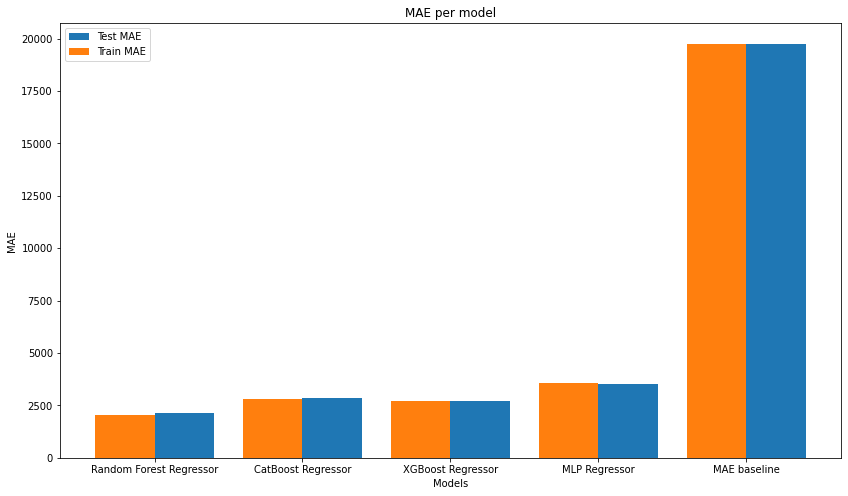

In [36]:
models_mae = ['Random Forest Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'MLP Regressor', 'MAE baseline']
train_mae = [rfr_train_mae, cbr_train_mae, xgb_train_mae, mlp_train_mae, mae_baseline]
test_mae = [rfr_test_mae, cbr_test_mae, xgb_test_mae, mlp_test_mae, mae_baseline]
bar_graph(models_mae, 'MAE', train_mae, test_mae, 2)

# R2 plotting

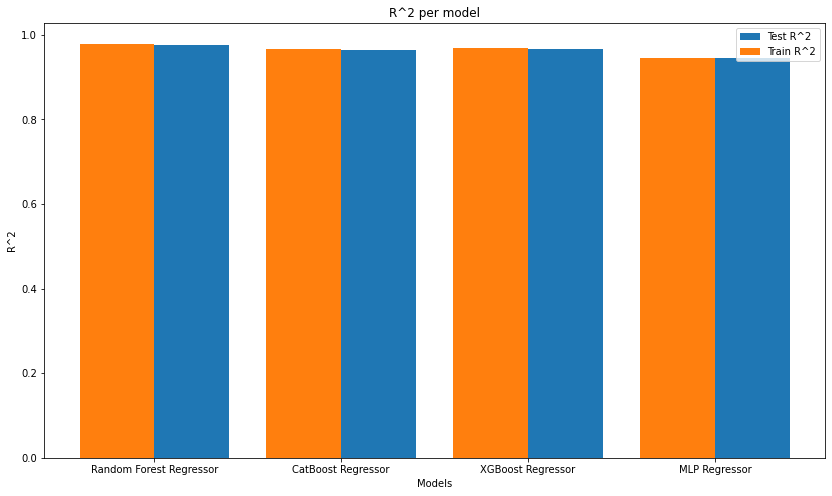

In [37]:
models_r2 = ['Random Forest Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'MLP Regressor']
train_r2 = [rfr_train_r2, cbr_train_r2, xgb_train_r2, mlp_train_r2]
test_r2 = [rfr_test_r2, cbr_test_r2, xgb_test_r2, mlp_test_r2]
bar_graph(models_r2, 'R^2', train_r2, test_r2, 2)

# Total Run Time, which include training and predicting.

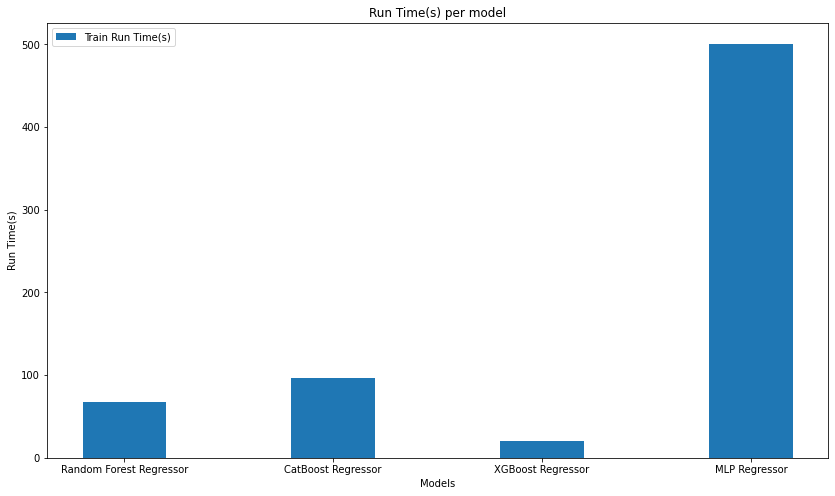

In [38]:
models_run_time = ['Random Forest Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'MLP Regressor']
run_time = [round(rfr_stop - rfr_start), round(cbr_stop - cbr_start), round(xgb_stop - xgb_start), round(mlp_stop - mlp_start)]
bar_graph(models_run_time, 'Run Time(s)', run_time, None, 1)

# Check base models will benefit from more data

In [39]:
def graph_learning_curve(name, model, tr_x, tr_y):
    arr = [25, 50, 150, 600, 3600, 25200, 50400, 100800, 192097]
    train_sizes, train_scores, test_scores = learning_curve(model, tr_x, tr_y, train_sizes=arr, cv=5, scoring='neg_mean_absolute_error')
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, test_scores_mean, label = 'Testing error')
    plt.ylabel('MAE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    st = 'Learning curve: ' + name
    plt.title(st, fontsize = 18, y = 1.03)
    plt.legend()

# Learning Curve for Random Forest Regressor

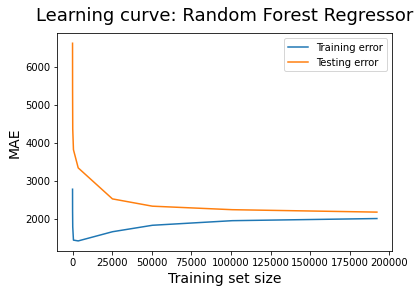

In [40]:
graph_learning_curve('Random Forest Regressor', RFRmodel, train_x_encoded, train_y_encoded)

# Learning Curve for CatBoost Regressor

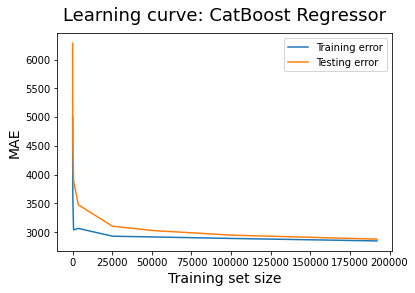

In [41]:
graph_learning_curve('CatBoost Regressor', CBRmodel, train_x, train_y)

# Learning Curve for XGBoost Regressor

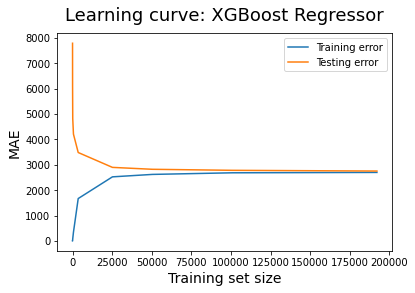

In [42]:
graph_learning_curve('XGBoost Regressor', XGBmodel, train_x_encoded, train_y_encoded)

# Learning Curve for MLP Regressor

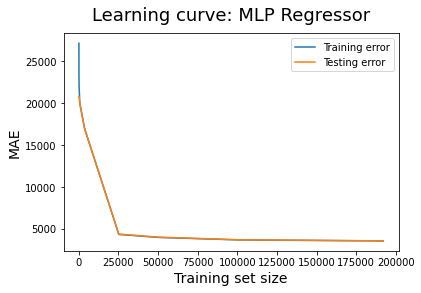

In [43]:
graph_learning_curve('MLP Regressor', MLPmodel, train_x_encoded, train_y_encoded)

# Conclusion: Models will not benefit from more data, Thus now we hypertune each model

In [44]:
#from sklearn.model_selection import GridSearchCV
#def hypertune(model, grid, train_sample, test_sample):
#    m = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=2)
#    return m.fit(train_sample, test_sample)

# Tune Random Forest Regressor

In [45]:
#Expected best (max_depth: 200 | n_estimators: 400)
#rfr_grid = {'max_depth':[200, 300], 
 #           'n_estimators': [400, 450]}
#rfr_model = RandomForestRegressor(random_state=1) 
#rfr_best_params = hypertune(rfr_model, rfr_grid, train_x_encoded, train_y_encoded)
rfr_tuned_start = time.time()
rfr_tuned_model = RandomForestRegressor(max_depth=200, n_estimators=400, random_state=1).fit(train_x_encoded, train_y_encoded)
rfr_tuned_train_pred_y = rfr_tuned_model.predict(train_x_encoded)
rfr_tuned_test_pred_y = rfr_tuned_model.predict(test_x_encoded)
rfr_tuned_stop = time.time()

# Tune CatBoost Regressor

In [46]:
#Expected best (max_depth: 16 | n_estimators: 600?)
#cbr_grid = {'max_depth': [16],
#           'n_estimators':[600, 1000]}
#cbr_model = CatBoostRegressor(random_state=1, cat_features=[0, 1, 2, 4, 5, 6], verbose=False)
#cbr_best_params = hypertune(cbr_model, cbr_grid, train_x, train_y)
cbr_tuned_start = time.time()
cbr_tuned_model = CatBoostRegressor(max_depth=16, n_estimators=600, cat_features=[0, 1, 2, 4, 5, 6], verbose=False, random_state=1).fit(train_x, train_y)
cbr_tuned_train_pred_y = cbr_tuned_model.predict(train_x)
cbr_tuned_test_pred_y = cbr_tuned_model.predict(test_x)
cbr_tuned_stop = time.time()

# Tune MLP

In [47]:
mlp_tuned_start = time.time()
mlp_tuned_model = MLPRegressor(random_state=1, learning_rate_init=.5, hidden_layer_sizes=300)
mlp_tuned_model.fit(train_x_encoded, train_y_encoded)
mlp_tuned_train_pred_y = mlp_tuned_model.predict(train_x_encoded)
mlp_tuned_test_pred_y = mlp_tuned_model.predict(test_x_encoded)
mlp_tuned_stop = time.time()

# Tune Xgboost

In [48]:
xgb_tuned_start = time.time()
xgb_tuned_model = xgb.XGBRegressor(random_state=1, n_estimators=500, max_depth=10)
xgb_tuned_model.fit(train_x_encoded, train_y_encoded)
xgb_tuned_train_pred_y = xgb_tuned_model.predict(train_x_encoded)
xgb_tuned_test_pred_y = xgb_tuned_model.predict(test_x_encoded)
xgb_tuned_stop = time.time()

# Compare Tuned Models

In [49]:
rfr_tuned_train_r2, rfr_tuned_test_r2, rfr_tuned_train_mae, rfr_tuned_test_mae = evaluate(rfr_tuned_model, train_x_encoded, train_y_encoded, test_x_encoded, test_y_encoded, rfr_tuned_train_pred_y, rfr_tuned_test_pred_y)
cbr_tuned_train_r2, cbr_tuned_test_r2, cbr_tuned_train_mae, cbr_tuned_test_mae = evaluate(cbr_tuned_model, train_x, train_y, test_x, test_y, cbr_tuned_train_pred_y, cbr_tuned_test_pred_y) 
xgb_tuned_train_r2, xgb_tuned_test_r2, xgb_tuned_train_mae, xgb_tuned_test_mae = evaluate(xgb_tuned_model, train_x_encoded, train_y_encoded, test_x_encoded, test_y_encoded, xgb_tuned_train_pred_y, xgb_tuned_test_pred_y)
mlp_tuned_train_r2, mlp_tuned_test_r2, mlp_tuned_train_mae, mlp_tuned_test_mae = evaluate(mlp_tuned_model, train_x_encoded, train_y_encoded, test_x_encoded, test_y_encoded, mlp_tuned_train_pred_y, mlp_tuned_test_pred_y)

# MAE

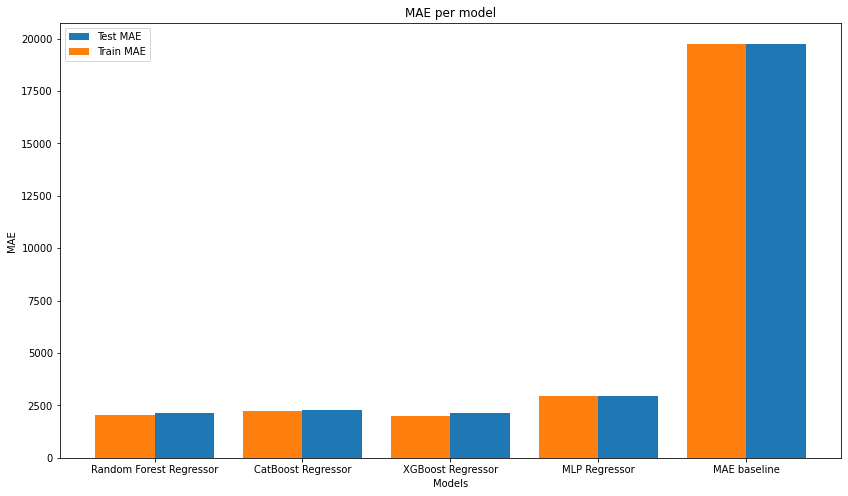

In [50]:
models_mae_tuned = ['Random Forest Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'MLP Regressor', 'MAE baseline']
train_mae_tuned = [rfr_tuned_train_mae, cbr_tuned_train_mae, xgb_tuned_train_mae, mlp_tuned_train_mae, mae_baseline]
test_mae_tuned = [rfr_tuned_test_mae, cbr_tuned_test_mae, xgb_tuned_test_mae, mlp_tuned_test_mae, mae_baseline]
bar_graph(models_mae_tuned, 'MAE', train_mae_tuned, test_mae_tuned, 2)

# R^2

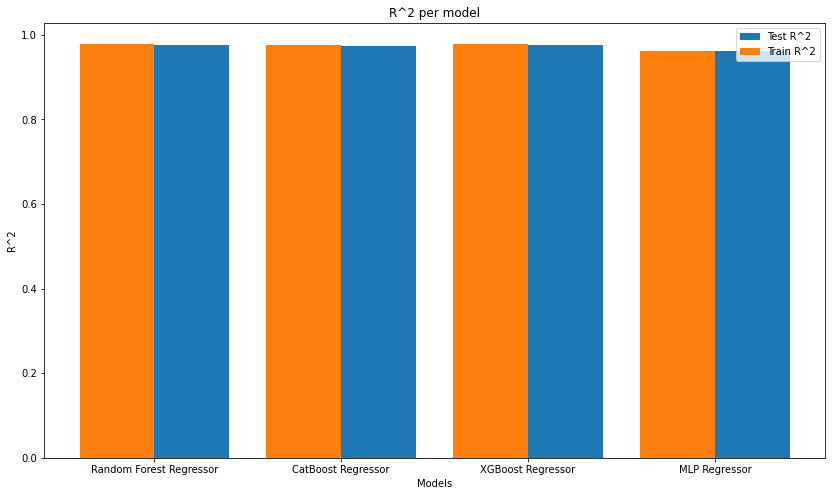

In [51]:
models_r2_tuned = ['Random Forest Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'MLP Regressor']
train_r2_tuned = [rfr_tuned_train_r2, cbr_tuned_train_r2, xgb_tuned_train_r2, mlp_tuned_train_r2]
test_r2_tuned = [rfr_tuned_test_r2, cbr_tuned_test_r2, xgb_tuned_test_r2, mlp_tuned_test_r2]
bar_graph(models_r2_tuned, 'R^2', train_r2_tuned, test_r2_tuned, 2)

# Runtime

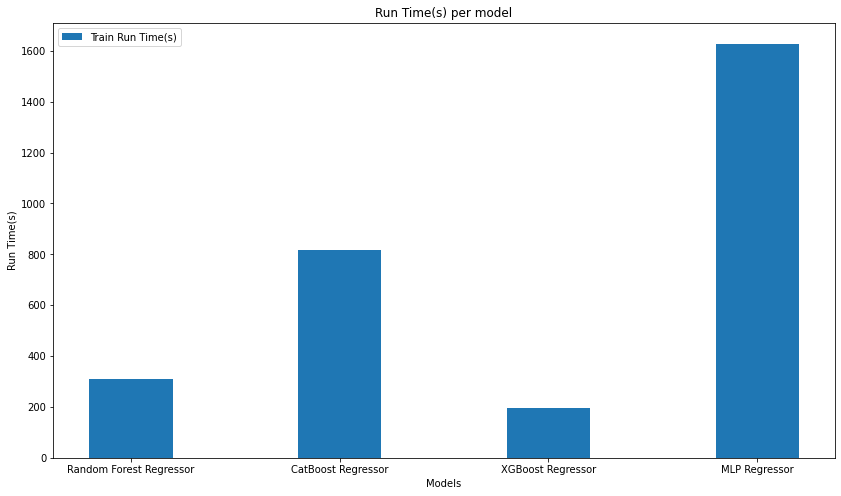

In [52]:
models_run_time_tuned = ['Random Forest Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'MLP Regressor']
run_time_tuned = [round(rfr_tuned_stop - rfr_tuned_start), round(cbr_tuned_stop - cbr_tuned_start), round(xgb_tuned_stop - xgb_tuned_start), round(mlp_tuned_stop - mlp_tuned_start)]
bar_graph(models_run_time_tuned, 'Run Time(s)', run_time_tuned, None, 1)

# Evaluation table of new models. Don't need baseline.

In [53]:
train_mae_tuned.pop()
test_mae_tuned.pop()

19759.892536085892

In [54]:
train_mae_tuned = [round(num) for num in train_mae_tuned]
train_r2_tuned = [round(num, 4) for num in train_r2_tuned]

test_mae_tuned = [round(num) for num in test_mae_tuned]
test_r2_tuned = [round(num, 4) for num in test_r2_tuned]

In [55]:
evaluation_table_train_tuned = create_eval_table(train_mae_tuned, train_r2_tuned, run_time_tuned)

evaluation_table_train_tuned

,Model,MAE,R^2,Train and Predict Run Time (s)
0,Random Forest Regressor,2021,0.9791,310
1,Catboost Regressor,2209,0.9762,815
2,XGBoost Regressor,2004,0.9792,194
3,MLP Regressor,2934,0.9618,1628


In [56]:
evaluation_table_test_tuned = create_eval_table(test_mae_tuned, test_r2_tuned, run_time_tuned)

evaluation_table_test_tuned

,Model,MAE,R^2,Train and Predict Run Time (s)
0,Random Forest Regressor,2148,0.9763,310
1,Catboost Regressor,2300,0.9742,815
2,XGBoost Regressor,2140,0.9765,194
3,MLP Regressor,2945,0.9614,1628


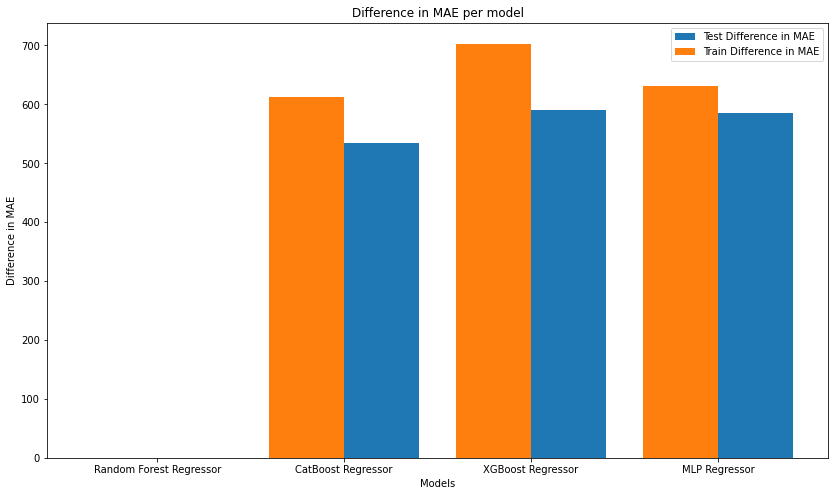

In [57]:
models = ['Random Forest Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'MLP Regressor']
train_difference = [2021 - 2021 , 2822 - 2209, 2707 - 2004, 3565 - 2934]
test_difference = [0, 535, 591, 585]
bar_graph(models, 'Difference in MAE', train_difference, test_difference, 2)

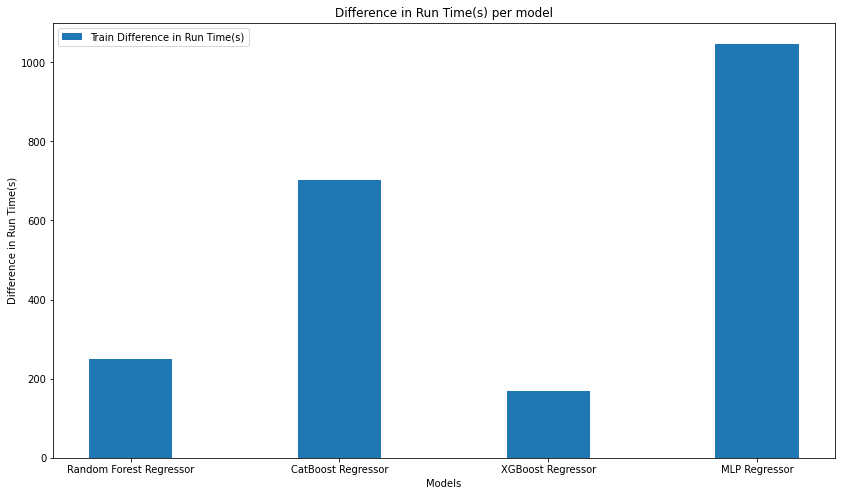

In [58]:
models = ['Random Forest Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'MLP Regressor']
train_difference = [320 - 69 , 799 - 97, 190 - 21, 1494 - 447]
bar_graph(models, 'Difference in Run Time(s)', train_difference, None, 1)

# Feature Importances

In [59]:
def toString(list, isCatboost):
    newList = []
    
    for i in range(len(list)):
        a = "{:.4f}".format(list[i])
        if isCatboost:
            newList.append(round(float(a), 2))
        else:
            newList.append(round(float(a) * 100, 2))
        
    return newList

In [60]:
def create_pie(feat_importance, feat_names, title):
    
    labels_list = []
    for feat_name, importance in zip(feat_names, feat_importance):
        
        label_str = ""
        
        label_str += feat_name
        label_str += "  "
        label_str += str(importance)
        label_str += "%"
        
        labels_list.append(label_str)
    
    fig, ax = plt.subplots(figsize=(5,24))
    ax.pie(feat_importance, colors=["#ff0000", "#000000", "#ff8000", "#00ff40", "#00bfff", "#8000ff", "#ff00bf", "#00ffff"])
    plt.title(title)
    ax.legend(labels=labels_list, title='Features',loc='center right', bbox_to_anchor=(1, 0, .5, 1))
    plt.show()
    

In [61]:
def combine_feature_importance(feat_importance):
    
    importance_list = [feat_importance[0], feat_importance[1]]
    
    airline_importance = 0
    source_city_importance = 0
    departure_time_importance = 0
    arrival_time_importance = 0
    destination_city_importance = 0
    class_importance = 0
    
    for i in range(2, len(feat_importance)):
        
        if i >= 2 and i <= 7:
            airline_importance += feat_importance[i]
        elif i >= 8 and i <= 13:
            source_city_importance += feat_importance[i]
        elif i >= 14 and i <= 19:
            departure_time_importance += feat_importance[i]
        elif i >= 20 and i <= 25:
            arrival_time_importance += feat_importance[i]
        elif i >= 26 and i <= 31:
            destination_city_importance += feat_importance[i]
        else:
            class_importance += feat_importance[i]
    
    importance_list.append(airline_importance)
    importance_list.append(source_city_importance)
    importance_list.append(departure_time_importance)
    importance_list.append(arrival_time_importance)
    importance_list.append(destination_city_importance)
    importance_list.append(class_importance)
    
    return importance_list

In [62]:
RFR_importance = toString((RFRmodel.feature_importances_).tolist(), False)
CBR_importance = toString((CBRmodel.feature_importances_).tolist(), True)
XGB_importance = toString((XGBmodel.feature_importances_).tolist(), False)

In [63]:
CBR_importance = [round(num, 2) for num in CBR_importance]

In [64]:
feature_names = ["stops", "duration", "airline", "source_city", "departure_time", "arrival_time", "destination_city", "class"]
RFR_updated_importance = combine_feature_importance(RFR_importance)
XGB_updated_importance = combine_feature_importance(XGB_importance)

In [65]:
RFR_updated_importance = [round(num, 2) for num in RFR_updated_importance]
XGB_updated_importance = [round(num, 2) for num in XGB_updated_importance]

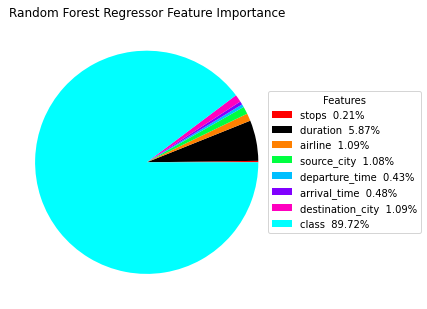

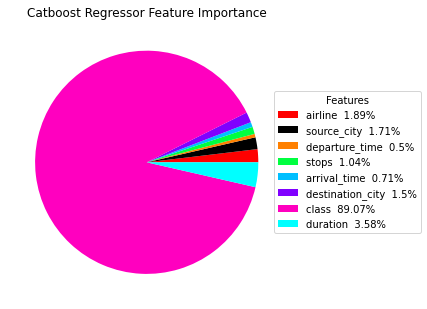

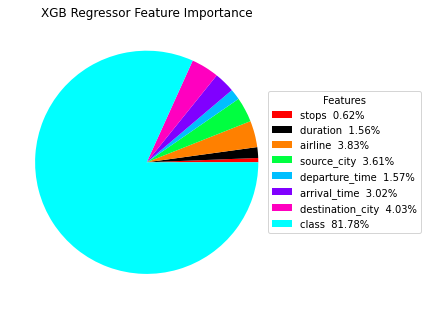

In [66]:
create_pie(RFR_updated_importance, feature_names, "Random Forest Regressor Feature Importance")
create_pie(CBR_importance, nonencoded_features, "Catboost Regressor Feature Importance")
create_pie(XGB_updated_importance, feature_names, "XGB Regressor Feature Importance")

# Average of all Predictions

In [67]:
def average_predictions(*preds):
    
    average_predictions_list = []
    
    num_args = len(preds)
    
    for i in range(len(preds[0])):
        average_pred = 0
        for j in range(num_args):
            average_pred += preds[j][i]
        average_predictions_list.append(round(average_pred / num_args))
    
    return average_predictions_list
        

In [68]:
#cbr_tuned_test_pred_y = np.genfromtxt("../input/saved-predictions/cbr_tuned_test_pred_y.csv", delimiter=",")
#mlp_tuned_test_pred_y = np.genfromtxt("../input/saved-predictions/mlp_tuned_test_pred_y.csv", delimiter=",")
#rfr_tuned_test_pred_y = np.genfromtxt("../input/saved-predictions/rfr_tuned_test_pred_y.csv", delimiter=",")
#xgb_tuned_test_pred_y = np.genfromtxt("../input/saved-predictions/xgb_tuned_test_pred_y.csv", delimiter=",")

In [69]:
average4_predictions = average_predictions(rfr_tuned_test_pred_y, cbr_tuned_test_pred_y, xgb_tuned_test_pred_y, mlp_tuned_test_pred_y)
average4_predictions_mae = mean_absolute_error(average4_predictions, test_y)

average3_predictions = average_predictions(rfr_tuned_test_pred_y, cbr_tuned_test_pred_y, xgb_tuned_test_pred_y)
average3_predictions_mae = mean_absolute_error(average3_predictions, test_y)

average2_predictions = average_predictions(rfr_tuned_test_pred_y, xgb_tuned_test_pred_y)
average2_predictions_mae = mean_absolute_error(average2_predictions, test_y)

In [70]:
xgb_baseline_error = mean_absolute_error(xgb_tuned_test_pred_y, test_y)

In [71]:
average_predictions_table = pd.DataFrame({
    
    "Average of 4 Models" : [round(average4_predictions_mae)],
    "Average of 3 Models" : [round(average3_predictions_mae)],
    "Average of 2 Models" : [round(average2_predictions_mae)],
    "XGB Baseline" : [round(xgb_baseline_error)]
    
})

average_predictions_table

,Average of 4 Models,Average of 3 Models,Average of 2 Models,XGB Baseline
0,2271,2174,2141,2140


# Scatterplot of differences in predictions vs real values

In [72]:
def scatterplot_difference(model_test_pred, color_point):
    
    model_preds_difference_df = pd.DataFrame({
        
        "Real Values (10000s)" : [math.floor(num / 10000) for num in test_y],
        "Prediction Difference" : model_test_pred - test_y
        
    })
    
    sns.scatterplot(x="Real Values (10000s)", y="Prediction Difference", data=model_preds_difference_df, color=color_point)

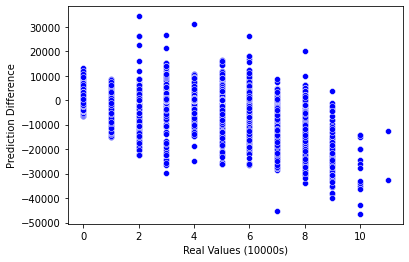

In [73]:
scatterplot_difference(rfr_tuned_test_pred_y, "blue")

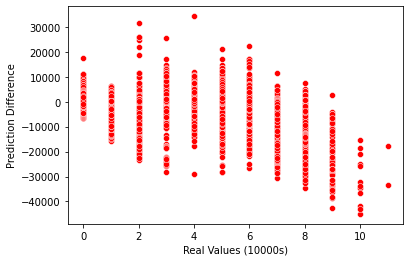

In [74]:
scatterplot_difference(cbr_tuned_test_pred_y, "red")

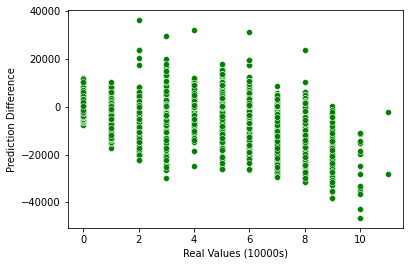

In [75]:
scatterplot_difference(xgb_tuned_test_pred_y, "green")

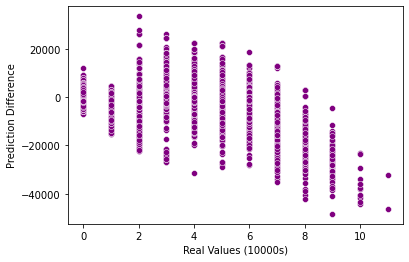

In [76]:
scatterplot_difference(mlp_tuned_test_pred_y, "purple")

# Find indices for rows of economy and business class

In [77]:
def split_class(train_data, test_data):
    
    train_indices_economy = []
    train_indices_business = []
    test_indices_economy = []
    test_indices_business = []
    
    for i in range(len(train_data)):
        if train_data[i][33] == 1:
            train_indices_economy.append(i)
        else:
            train_indices_business.append(i)
    
    for i in range(len(test_data)):
        if test_data[i][33] == 1:
            test_indices_economy.append(i)
        else:
            test_indices_business.append(i)
        
    return train_indices_economy, train_indices_business, test_indices_economy, test_indices_business

In [78]:
train_indices_economy, train_indices_business, test_indices_economy, test_indices_business = split_class(train_x_encoded, test_x_encoded)

In [79]:
def calculate_prediction_differences(model_pred_y, target):

    economy_difference = sum(model_pred_y[test_indices_economy]) - sum(target[test_indices_economy])
    business_difference = sum(model_pred_y[test_indices_business]) - sum(target[test_indices_business])
    
    return economy_difference, business_difference

In [80]:
def calculate_over_under_pcts(model_preds, target):
    
    num_over = 0
    num_under = 0
    
    for i in range(len(model_preds)):
        if model_preds[i] > target[i]:
            num_over += 1
        else:
            num_under += 1
    
    num_over_pct = (num_over / len(model_preds)) * 100
    num_under_pct = (num_under / len(model_preds)) * 100
    
    return round(num_over_pct), round(num_under_pct), num_over, num_under

In [81]:
def calculate_over_under_avgs(model_diffs):
    under_vals = 0
    over_vals = 0
    under_counter = 0
    over_counter = 0
    for i in range(len(model_diffs)):
        if model_diffs[i] > 0:
            over_vals += model_diffs[i]
            over_counter += 1
        if model_diffs[i] < 0:
            under_vals += model_diffs[i]
            under_counter += 1
    return round(over_vals / over_counter), round(under_vals / under_counter)

In [82]:
def calculate_differences(model_preds_y, target):
    diff = model_preds_y - target
    return diff

In [83]:
rfr_over_avg, rfr_under_avg = calculate_over_under_avgs(calculate_differences(rfr_tuned_test_pred_y, test_y_encoded))
cbr_over_avg, cbr_under_avg = calculate_over_under_avgs(calculate_differences(cbr_tuned_test_pred_y, test_y_encoded))
xgb_over_avg, xgb_under_avg = calculate_over_under_avgs(calculate_differences(xgb_tuned_test_pred_y, test_y_encoded))
mlp_over_avg, mlp_under_avg = calculate_over_under_avgs(calculate_differences(mlp_tuned_test_pred_y, test_y_encoded))

In [84]:
rfr_economy_difference, rfr_business_difference = calculate_prediction_differences(rfr_tuned_test_pred_y, test_y_encoded)
cbr_economy_difference, cbr_business_difference = calculate_prediction_differences(cbr_tuned_test_pred_y, test_y_encoded)
xgb_economy_difference, xgb_business_difference = calculate_prediction_differences(xgb_tuned_test_pred_y, test_y_encoded)
mlp_economy_difference, mlp_business_difference = calculate_prediction_differences(mlp_tuned_test_pred_y, test_y_encoded)

In [85]:
rfr_over_pct, rfr_under_pct, rfr_num_over, rfr_num_under = calculate_over_under_pcts(rfr_tuned_test_pred_y, test_y_encoded)
cbr_over_pct, cbr_under_pct, cbr_num_over, cbr_num_under = calculate_over_under_pcts(cbr_tuned_test_pred_y, test_y_encoded)
xgb_over_pct, xgb_under_pct, xgb_num_over, xgb_num_under = calculate_over_under_pcts(xgb_tuned_test_pred_y, test_y_encoded)
mlp_over_pct, mlp_under_pct, mlp_num_over, mlp_num_under = calculate_over_under_pcts(mlp_tuned_test_pred_y, test_y_encoded)

# Table that shows our predictions and their differences from the real values

In [86]:
differences_table = pd.DataFrame({
    
    "Model" : ["Random Forest", "Catboost", "XGBoost", "MLP"],
    "Total Economy Difference" : [round(rfr_economy_difference / 1000), round(cbr_economy_difference / 1000), round(xgb_economy_difference / 1000), round(mlp_economy_difference / 1000)],
    "Total Business Difference" : [round(rfr_business_difference / 1000), round(cbr_business_difference / 1000), round(xgb_business_difference / 1000), round(mlp_business_difference / 1000)],
    "Percentage Over" : [rfr_over_pct, cbr_over_pct, xgb_over_pct, mlp_over_pct],
    "Percentage Under" : [rfr_under_pct, cbr_under_pct, xgb_under_pct, mlp_under_pct],
    "Num Values Over" : [rfr_num_over, cbr_num_over, xgb_num_over, mlp_num_over],
    "Num Values Under" : [rfr_num_under, cbr_num_under, xgb_num_under, mlp_num_under],
    "Avg When Overpredicting" : [rfr_over_avg, cbr_over_avg, xgb_over_avg, mlp_over_avg],
    "Avg When Underpredicting" : [rfr_under_avg, cbr_under_avg, xgb_under_avg, mlp_under_avg]
})

differences_table #in 1000s

,Model,Total Economy Difference,Total Business Difference,Percentage Over,Percentage Under,Num Values Over,Num Values Under,Avg When Overpredicting,Avg When Underpredicting
0,Random Forest,-575,-217,70,30,42272,17759,1516,-4073
1,Catboost,-314,-839,68,32,40738,19293,1680,-3608
2,XGBoost,-487,-128,72,28,42971,17060,1487,-3783
3,MLP,6139,-14777,61,39,36680,23351,2293,-3971


# Ensemble

In [87]:
rfr_e = RandomForestRegressor(max_depth=200, n_estimators=400, random_state=1)
mlp_e = MLPRegressor(random_state=1, learning_rate_init=.5, hidden_layer_sizes=300)
xgb_e = xgb.XGBRegressor(random_state=1, n_estimators=500, max_depth=10)
ensemble_start = time.time()
ensemble = VotingRegressor([('Random Forest Regressor', rfr_e), ('XGBoost Regressor', xgb_e), ('Multilayer perception', mlp_e)])
ensemble_test_pred_y = ensemble.fit(train_x_encoded, train_y_encoded).predict(test_x_encoded)
ensemble_train_pred_y = ensemble.predict(train_x_encoded)
ensemble_end = time.time()

In [88]:
ensemble_train_r2, ensemble_test_r2, ensemble_train_mae, ensemble_test_mae = evaluate(ensemble, train_x_encoded, train_y_encoded, test_x_encoded, test_y_encoded, ensemble_train_pred_y, ensemble_test_pred_y)

In [89]:
print("Ensemble Train Mae", ensemble_train_mae)
print("Ensemble Test Mae", ensemble_test_mae)

Ensemble Train Mae 2201.0505036101135
Ensemble Test Mae 2289.825189701154


# Train and Test only economy and then business datasets

In [90]:
economy_xgb_model = xgb.XGBRegressor(random_state=1, n_estimators=500, max_depth=10)

economy_xgb_model.fit(train_x_encoded[train_indices_economy], train_y_encoded[train_indices_economy])
economy_xgb_pred = economy_xgb_model.predict(test_x_encoded[test_indices_economy])

mean_absolute_error(economy_xgb_pred, test_y_encoded[test_indices_economy])

2022.1581333608626

In [91]:
business_xgb_model = xgb.XGBRegressor(random_state=1, n_estimators=500, max_depth=10)

business_xgb_model.fit(train_x_encoded[train_indices_business], train_y_encoded[train_indices_business])
business_xgb_pred = business_xgb_model.predict(test_x_encoded[test_indices_business])

mean_absolute_error(business_xgb_pred, test_y_encoded[test_indices_business])

2401.328385195761

# XGBoost Appears to be the best performing model in terms of MAE and runtime. This is why we choose this model to solve this specific problem and will now try to improve it by implementing a bias to the prediction value

# Train-test split, however we will have 2 test sets to evaluate the effectiveness of introducing a bias

In [92]:
nonencoded_features = ["airline", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class", "duration"]
xgb_encoded_features = encoded_dataset.columns.tolist()
xgb_encoded_features = np.delete(encoded_features, 2, axis=0)

xgb_train_x, xgb_test_x, xgb_train_y, xgb_test_y = train_test_split(all_x_encoded, all_y_encoded, test_size=.3, random_state=1)
xgb_test_x, xgb_test2_x, xgb_test_y, xgb_test2_y = train_test_split(xgb_test_x, xgb_test_y, test_size = .5, random_state=1)

xgb_train_x.shape, xgb_train_y.shape, xgb_test_x.shape, xgb_test_y.shape, xgb_test2_x.shape, xgb_test2_y.shape

((210107, 34), (210107,), (45023, 34), (45023,), (45023, 34), (45023,))

# Train model, make predictions on both test data sets

In [93]:
xgb_final_model = xgb.XGBRegressor(random_state=1, n_estimators=500, max_depth=10)
xgb_final_model.fit(xgb_train_x, xgb_train_y)
xgb_final_train_pred_y = xgb_final_model.predict(xgb_train_x)
xgb_final_test_pred_y = xgb_final_model.predict(xgb_test_x)
xgb_final_test2_pred_y = xgb_final_model.predict(xgb_test2_x)

# Calculate performance metrics

In [94]:
xgb_final_train_r2, xgb_final_test_r2, xgb_final_train_mae, xgb_final_test_mae = evaluate(xgb_final_model, xgb_train_x, xgb_train_y, xgb_test_x, xgb_test_y, xgb_final_train_pred_y, xgb_final_test_pred_y)
xgb_final_over_avg, xgb_final_under_avg = calculate_over_under_avgs(calculate_differences(xgb_final_test_pred_y, xgb_test_y))

In [95]:
xgb_final_over_pct, xgb_final_under_pct, xgb_final_num_over, xgb_final_num_under = calculate_over_under_pcts(xgb_final_test_pred_y, xgb_test_y)

In [96]:
pd.DataFrame({
    
    "Model" : ["XGBoost"],
    "Train MAE" : [round(xgb_final_train_mae)],
    "Test MAE" : [round(xgb_final_test_mae)],
    "Percentage Over" : [xgb_final_over_pct],
    "Percentage Under" : [xgb_final_under_pct],
    "Num Values Over" : [xgb_final_num_over],
    "Num Values Under" : [xgb_final_num_under],
    "Avg When Overpredicting" : [xgb_final_over_avg],
    "Avg When Underpredicting" : [xgb_final_under_avg]
})

,Model,Train MAE,Test MAE,Percentage Over,Percentage Under,Num Values Over,Num Values Under,Avg When Overpredicting,Avg When Underpredicting
0,XGBoost,1994,2146,72,28,32205,12818,1506,-3755


# Add Bias to 2nd test set based on avg values when overpredicting/underpredicting

In [97]:
def addBias(arr, label, overValue, underValue):
    
    returnList = arr.copy()
    
    probability_over = xgb_final_num_over/(xgb_final_num_over + xgb_final_num_under)
    probability_under = 1 - probability_over
    calibration_value = (-abs(overValue*probability_over) + abs(underValue*probability_under))
    
    for i in range(len(arr)):
        returnList[i] = arr[i] + calibration_value
        
    return returnList

In [98]:
xgb_test2_pred_y_with_bias = addBias(xgb_final_test2_pred_y, xgb_test2_y, xgb_final_over_avg, xgb_final_under_avg)

In [99]:
xgb_calibrated_train_r2, xgb_calibrated_test_r2, xgb_calibrated_train_mae, xgb_calibrated_test_mae = evaluate(xgb_final_model, xgb_train_x, xgb_train_y, xgb_test2_x, xgb_test2_y, xgb_final_train_pred_y, xgb_test2_pred_y_with_bias)
xgb_calibrated_over_avg, xgb_calibrated_under_avg = calculate_over_under_avgs(calculate_differences(xgb_test2_pred_y_with_bias, xgb_test2_y))
xgb_calibrated_over_pct, xgb_calibrated_under_pct, xgb_calibrated_num_over, xgb_calibrated_num_under = calculate_over_under_pcts(xgb_test2_pred_y_with_bias, xgb_test2_y)

In [100]:
pd.DataFrame({
    
    "Model" : ["XGBoost"],
    "Train R^2" : [xgb_calibrated_train_r2],
    "Test R^2" : [xgb_calibrated_test_r2],
    "Train MAE" : [round(xgb_calibrated_train_mae)],
    "Test MAE" : [round(xgb_calibrated_test_mae)],
    "Percentage Over" : [xgb_calibrated_over_pct],
    "Percentage Under" : [xgb_calibrated_under_pct],
    "Num Values Over" : [xgb_calibrated_num_over],
    "Num Values Under" : [xgb_calibrated_num_under],
    "Avg When Overpredicting" : [xgb_calibrated_over_avg],
    "Avg When Underpredicting" : [xgb_calibrated_under_avg]
})

,Model,Train R^2,Test R^2,Train MAE,Test MAE,Percentage Over,Percentage Under,Num Values Over,Num Values Under,Avg When Overpredicting,Avg When Underpredicting
0,XGBoost,0.979274,0.976507,1994,2149,70,30,31504,13519,1527,-3598


# Final Model's MAE Value

In [101]:
print("Test 2's MAE Value: " , round(xgb_calibrated_test_mae))

Test 2's MAE Value:  2149
